In [7]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import datasets
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

/home/nuclea/miniconda3/envs/common/lib/python3.10/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


device(type='cpu')

In [65]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, stride=1, downsample=None):
        super(Block, self).__init__()
        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, bias=False, padding=1)
        self.bn = nn.BatchNorm2d(out_channels)
        self.conv2 = nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, bias=False, padding=1)
        self.downsample = downsample
    def forward(self, X):
        identity = X
        
        # this implements dotted line in the diagram
        if self.downsample is not None:
            identity = self.downsample(X)
        out = F.relu(self.bn(self.conv1(X)))
        out = self.bn(self.conv2(out))
        out += identity
        out = F.relu(out)
        return out

class ResNet(nn.Module):
    def __init__(self, block, layers, num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64
        self.conv1 = nn.Sequential(
            nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3),
            nn.BatchNorm2d(64),
            nn.ReLU()
        )
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer0 = self._make_layer(block, 64, layers[0], stride=1)
        self.layer1 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer2 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer3 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.fc = nn.Linear(512, num_classes)
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.in_planes != planes:
            downsample = nn.Sequential(
                nn.Conv2d(self.in_planes, planes, stride=stride, kernel_size=1),
                nn.BatchNorm2d(planes),
            )
        layers = []
        layers.append(block(self.in_planes, planes, stride, downsample))
        self.in_planes = planes
        for i in range(1, blocks):
            layers.append(block(self.in_planes, planes))
        return nn.Sequential(*layers)
    def forward(self, X):
        X = self.conv1(X)
        X = self.maxpool(X)
        X = self.layer0(X)
        X = self.layer1(X)
        X = self.layer2(X)
        X = self.layer3(X)

        X = self.avgpool(X)
        X = X.view(X.size(0), -1)
        X = self.fc(X)
        
        return X

In [66]:
model = ResNet(Block, [3,4,6,3]).to(device)

In [9]:
training_data = datasets.CIFAR10(
    root = "data",
    train=True,
    download=True,
    transform = ToTensor(),
)
test_data = datasets.CIFAR10(
    root = "data",
    train=False,
    download=True,
    transform = ToTensor(),
)

Files already downloaded and verified
Files already downloaded and verified


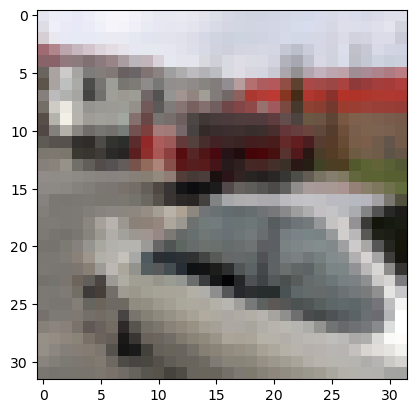

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.imshow(training_data.data[-1])
plt.show()

In [13]:
for X in test_data.data:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    break

Shape of X [N, C, H, W]: (32, 32, 3)


In [14]:
batch_size = 256
train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([256, 3, 32, 32])
Shape of y: torch.Size([256]) torch.int64


In [17]:
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.1, weight_decay=0.0001, momentum=0.9)

In [18]:
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    model.train()

    #forward pass and backpropagation
    for batch_id, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)
        # Computing forward pass
        pred = model(X)
        loss = loss_fn(pred, y)

        # backprop
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        loss = loss.item()
        batch_completed = (batch_id + 1)
        print(f"loss: {loss}  [{batch_completed}/{size}]")

In [67]:
epochs = 20
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss, optimizer)

Epoch 1
-------------------------------
loss: 2.6721086502075195  [1/50000]
loss: 2.633572578430176  [2/50000]
loss: 2.635538101196289  [3/50000]
loss: 2.6454899311065674  [4/50000]
loss: 2.5678534507751465  [5/50000]
loss: 2.627514123916626  [6/50000]
loss: 2.69796085357666  [7/50000]
loss: 2.5842556953430176  [8/50000]
loss: 2.7086615562438965  [9/50000]
loss: 2.712268352508545  [10/50000]
loss: 2.6758065223693848  [11/50000]
loss: 2.6989710330963135  [12/50000]
loss: 2.6465299129486084  [13/50000]
loss: 2.593540668487549  [14/50000]
loss: 2.631417751312256  [15/50000]
loss: 2.6509196758270264  [16/50000]
loss: 2.5717878341674805  [17/50000]
loss: 2.673353433609009  [18/50000]
loss: 2.6813087463378906  [19/50000]
loss: 2.6519172191619873  [20/50000]
loss: 2.653154134750366  [21/50000]
loss: 2.6016457080841064  [22/50000]
loss: 2.63923716545105  [23/50000]
loss: 2.693787097930908  [24/50000]
loss: 2.540621042251587  [25/50000]
loss: 2.5560758113861084  [26/50000]
loss: 2.6711399555206